In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn as nn
from einops import rearrange
import math
import torch
import numpy as np

In [3]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        """fixed trig projection"""
        # https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/guided_diffusion.py#Li115
        super().__init__()
        self.dim = dim

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(10000) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb


In [6]:
def get_1d_sincos_pos_embed(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000**omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out) # (M, D/2)
    emb_cos = np.cos(out) # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

In [9]:
pos_emb = get_1d_sincos_pos_embed(128, np.arange(512))

In [10]:
pos_emb.shape

(512, 128)

Text(50.722222222222214, 0.5, 'hidden dimension')

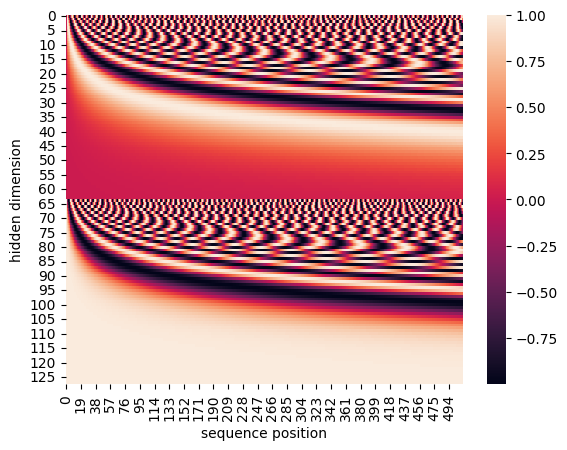

In [14]:
import seaborn as sns
sns.heatmap(pos_emb.T)
import matplotlib.pyplot as plt
plt.xlabel("sequence position")
plt.ylabel("hidden dimension")

In [1]:
from plaid.denoisers.modules import TimestepEmbedder

In [9]:
import torch

# t = torch.randint(0, 500, (64,))
t = torch.arange(500).long()

In [10]:
emb = TimestepEmbedder(64)

In [11]:
out = emb(t)
print(out.shape)

torch.Size([500, 64])


<Axes: >

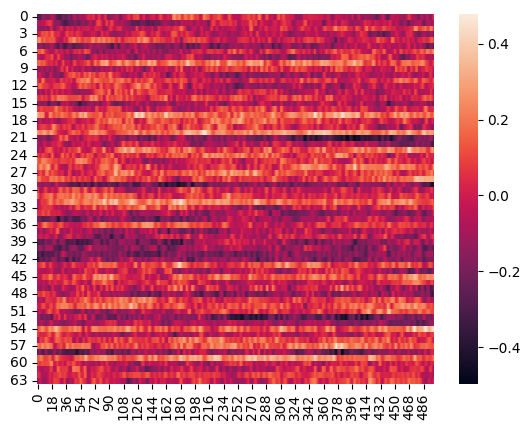

In [13]:
import seaborn as sns
sns.heatmap(out.T.detach().cpu().numpy())